# Градиентный бустинг


### Градиентный бустинг и случайный лес
Сравним, как ведут себя бустинг и случайный лес с ростом числа базовых алгоритмов.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

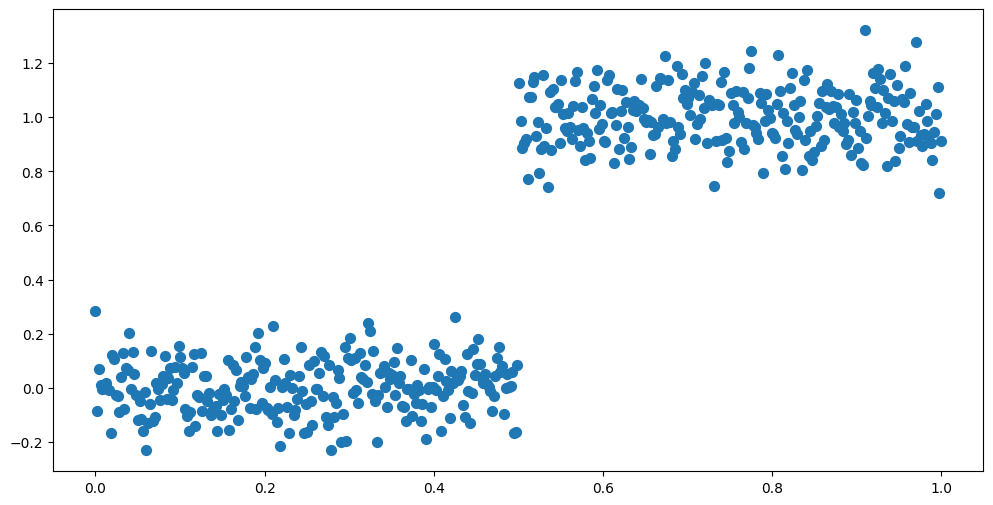

In [4]:
X_train = np.linspace(0, 1, 500)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (12, 6))
plt.scatter(X_train, Y_train, s=50)

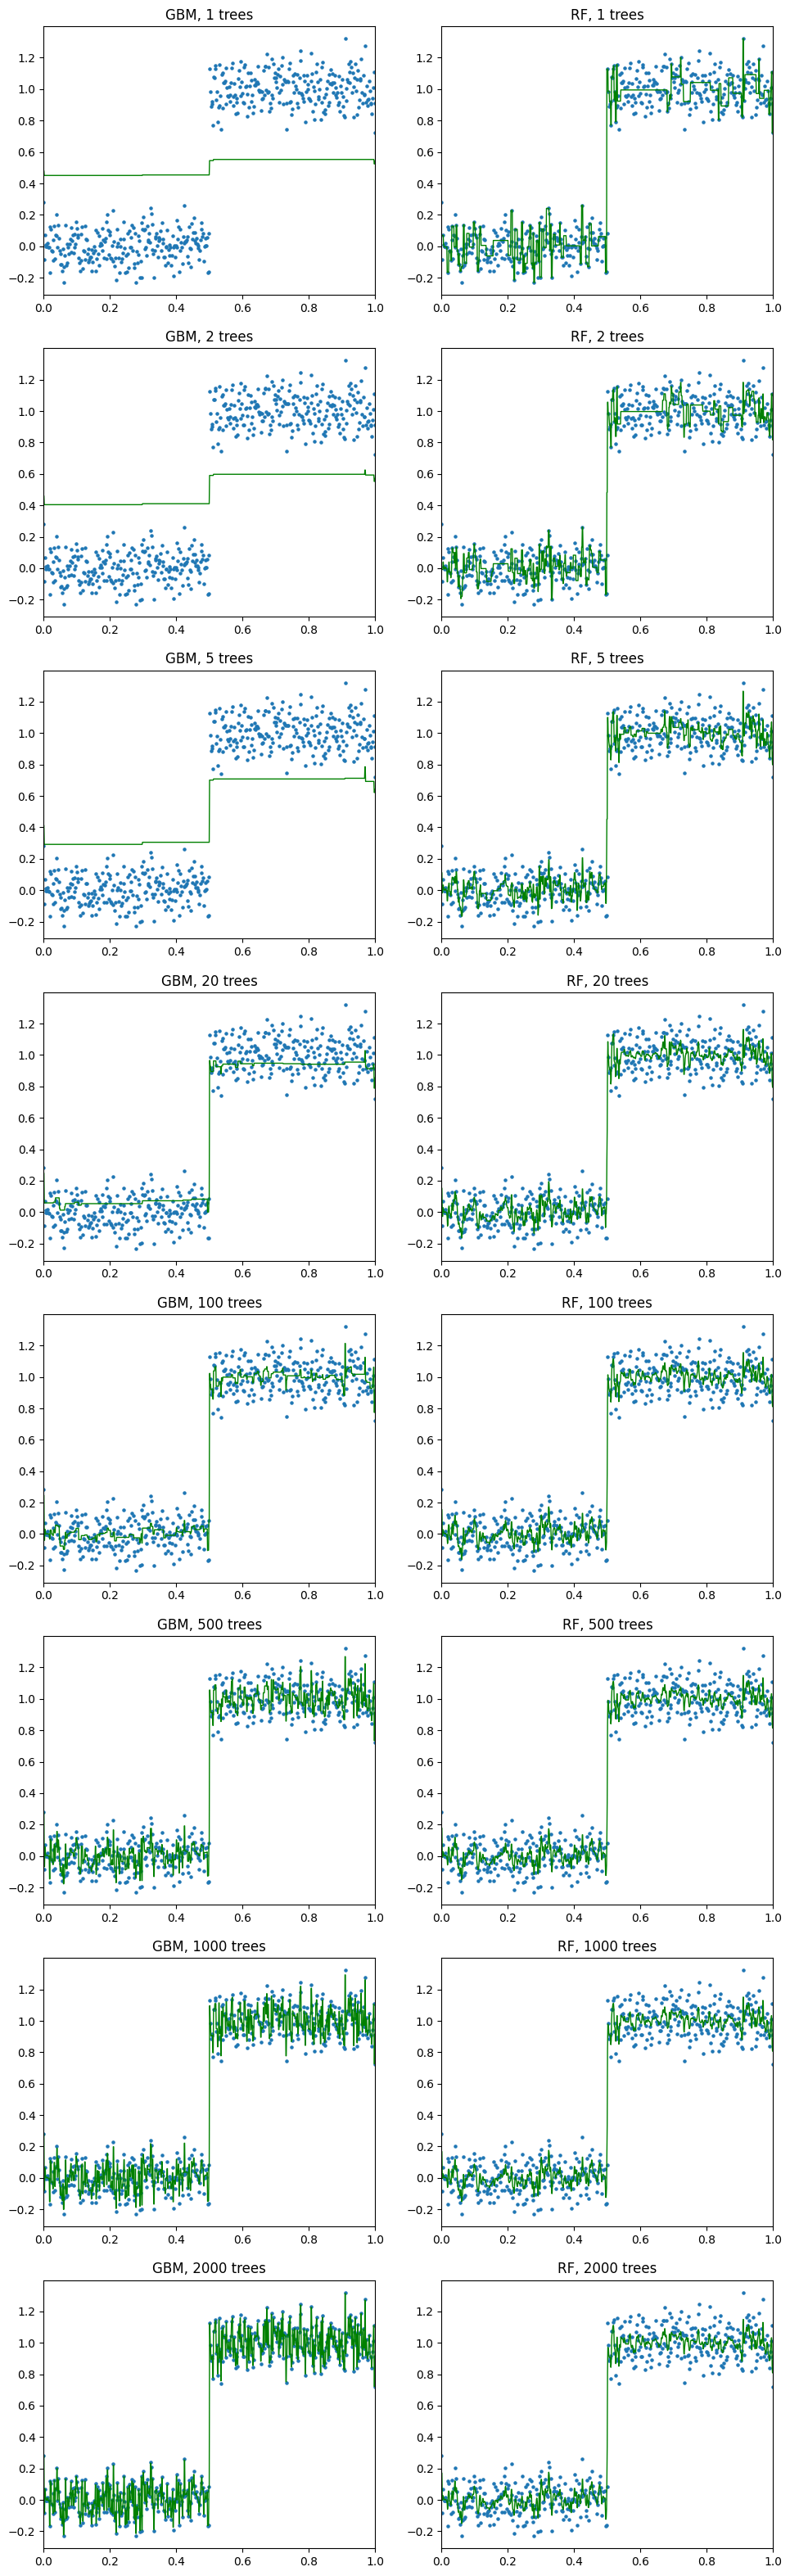

In [5]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(max_depth=10, warm_start=True)
gbm = GradientBoostingRegressor(warm_start=True)

X_train = X_train.reshape(-1, 1)
plt.figure(figsize=(11.5, 40))

sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    rf.n_estimators = s
    rf.fit(X_train, Y_train)

    gbm.n_estimators = s
    gbm.fit(X_train, Y_train)

    plt.subplot(8, 2, 2*i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=5)
    plt.plot(X_test, gbm.predict(X_test.reshape(-1, 1)), c='green', linewidth=1)
    plt.title('GBM, {} trees'.format(s))

    plt.subplot(8, 2, 2*i+2)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=5)
    plt.plot(X_test, rf.predict(X_test.reshape(-1, 1)), c='green', linewidth=1)
    plt.title('RF, {} trees'.format(s))


^

## Свойства градиентного бустинга над решающими деревьями

Пусть решается задача регрессии на одномерной выборке $X = \{ (x_i, y_i)\}_{i=1}^l,$ при этом истинная зависимость целевой переменной является линейной: $y(x) = ax + \varepsilon, \, \varepsilon \sim \mathcal{N} (0, \sigma^2).$ Допустим, не зная этого, вы обучили на выборке линейную регрессию и градиентный бустинг с функционалом MSE, и вам известно, что модели не переобучились. После этого вы получили новые данные и построили на них прогнозы обеих моделей, и оказалось, что для решающего дерева значение функционала ошибки на новых данных оказалось радикально выше, чем для линейной регрессии. Чем это может быть вызвано?

Допустим, обучающая выборка была получена из отрезка $[0; 10],$ обучим соответствующие модели и построим прогнозы для этого отрезка:

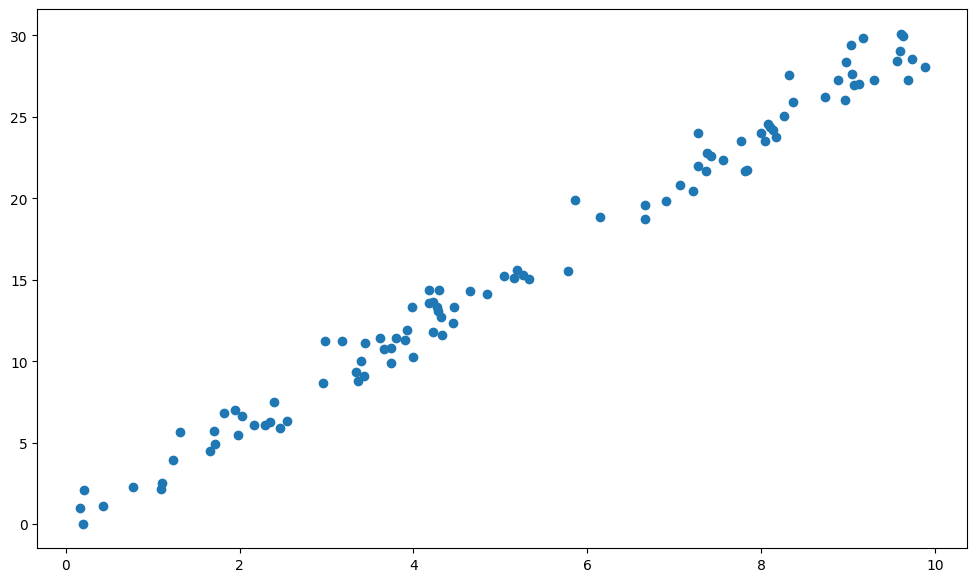

In [6]:
from numpy.random import rand, randn

set_size = 100
lin_coef = 3
sigma = 1

X_train = (rand(set_size) * 10).reshape(-1, 1)
Y_train = X_train * lin_coef + sigma * randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, Y_train)
gbm = GradientBoostingRegressor()
gbm.fit(X_train, Y_train.reshape(-1,))

GradientBoostingRegressor()

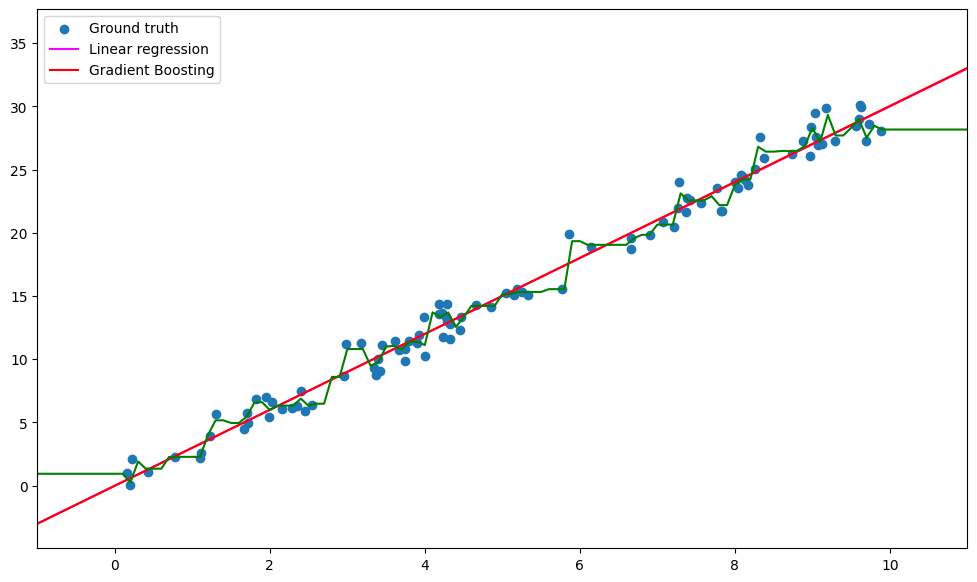

In [8]:
from numpy.random import rand, randn

grid = np.arange(-1, 12, 0.1).reshape(-1, 1)

plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)
plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, gbm.predict(grid), 'green')
plt.xlim([-1, 11])
plt.legend(['Ground truth', 'Linear regression', 'Gradient Boosting'], loc=0)

Предположим, что новые данные были получены из другой области пространства ответов, например, из отрезка $[20; 30]$:

LR test MSE =  1.1540003908175067
GBM test MSE =  2213.2428961698492


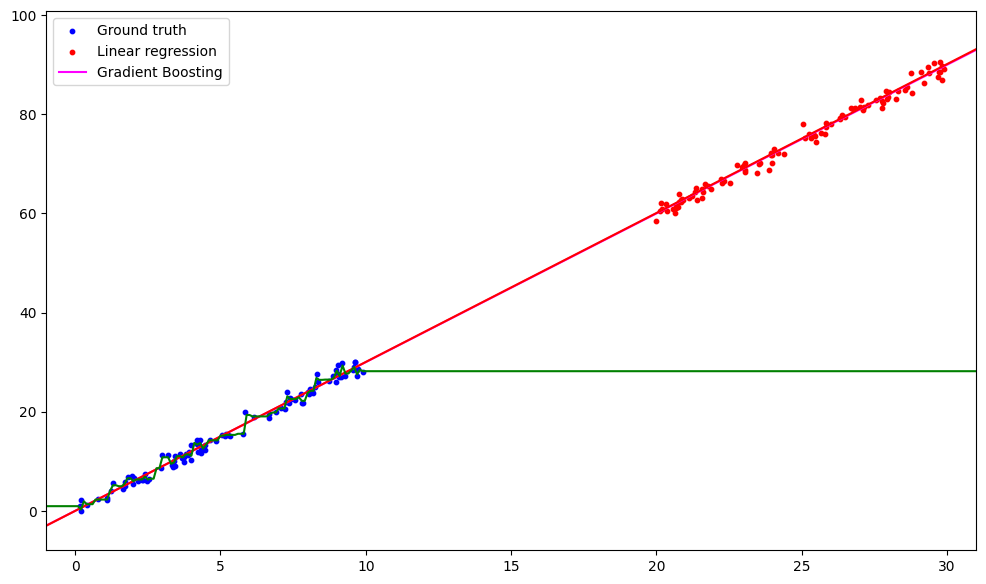

In [9]:
from numpy.random import rand, randn

grid = np.arange(-1, 32, 0.1).reshape(-1, 1)

X_test = (20 + rand(set_size) * 10).reshape(-1, 1)
Y_test = X_test * 3 + sigma * randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train, c='blue', s=10)
plt.scatter(X_test, Y_test, c='red', s=10)

plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red')
plt.plot(grid, gbm.predict(grid), 'green')
plt.xlim([-1, 31])
plt.legend(['Ground truth', 'Linear regression', 'Gradient Boosting'], loc=0)
print ('LR test MSE = ', mean_squared_error(Y_test, lr.predict(X_test)))
print ('GBM test MSE = ', mean_squared_error(Y_test, gbm.predict(X_test)))

 В этом случае предсказания линейной регрессии оказались гораздо ближе к истинной зависимости, что отразится и на значении функционала ошибки и метриках качества.

**Вывод**: Градиентный бустинг (как и деревья решений) непригодны для экстраполяции функций.

В качестве решения этой проблемы в некоторых случаях можно использовать [нормализацию](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization).

## Современные библиотеки градиентного бустинга

Ранее мы использовали наивную версию градиентного бустинга из scikit-learn, [описанную](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) в 1999 году Жеромом Фридманом. С тех пор было предложено много реализаций, которые оказываются лучше на практике. На сегодняшний день популярны три библиотеки, реализующие градиентный бустинг:
* XGBoost. После выхода быстро набрала популярность во многом за счет успехов в соревнованиях по анализу данных и оставалась стандартом до конца 2016 года.
* LightGBM. Отличительной чертой является быстрота построения композиции. Например, используется следующий трюк для ускорения обучения: при построении вершины дерева вместо перебора по всем значениям признака производится перебор значений гистограммы этого признака. Таким образом, вместо $O(\ell)$ требуется $O$(#bins). Кроме того, в отличие от других библиотек, которые строят дерево по уровням, LightGBM использует стратегию best-first, т.е. на каждом шаге строит вершину, дающую наибольшее уменьшение функционала -  ограничение на num_leaves получается более осмысленным.
* CatBoost. Библиотека от компании Яндекс, позволяет автоматически обрабатывать категориальные признаки. Так же отличается стратегия построения деревьев - применяются симметричные дерьвья. Кроме того, алгоритм является менее чувствительным к выбору конкретных гиперпараметров: за счёт этого уменьшается время, которое тратит человек на подбор оптимальных значений.

### Основные параметры

Здесь и далее будем рассматривать библиотеки LightGBM и CatBoost.

(LightGBM/CatBoost)
* objective – функционал, на который будет настраиваться композиция
* eta / learning_rate – темп (скорость) обучения
* num_iterations / n_estimators  – число итераций бустинга

#### Параметры, отвечающие за сложность деревьев
* max_depth – максимальная глубина каждого дерева
* max_leaves / num_leaves – максимальное число вершин в дереве
* gamma / min_gain_to_split – порог на уменьшение функции ошибки при расщеплении в дереве
* min_data_in_leaf – минимальное число объектов в листе
* subsample / bagging_fraction – какую часть объектов обучения использовать для построения одного дерева
* colsample_bytree / feature_fraction – какую часть признаков использовать для построения одного дерева

Начинать настройку можно с самых главных параметров: learning_rate и n_estimators. Обычно один из них фиксируют, а другой подбирают (например, фиксируют n_estimators=1000 и подбирают learning_rate). Следующим по важности является max_depth.




In [10]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

### Catboost

In [11]:
! pip install catboost

0.8711111111111112


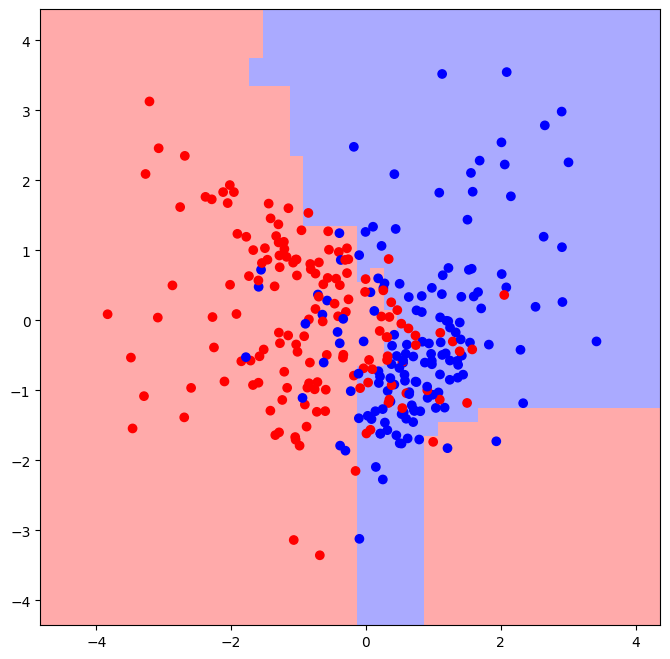

In [13]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(iterations=300, logging_level='Silent')
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

### LightGBM

[LightGBM] [Info] Number of positive: 356, number of negative: 344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508571 -> initscore=0.034289
[LightGBM] [Info] Start training from score 0.034289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

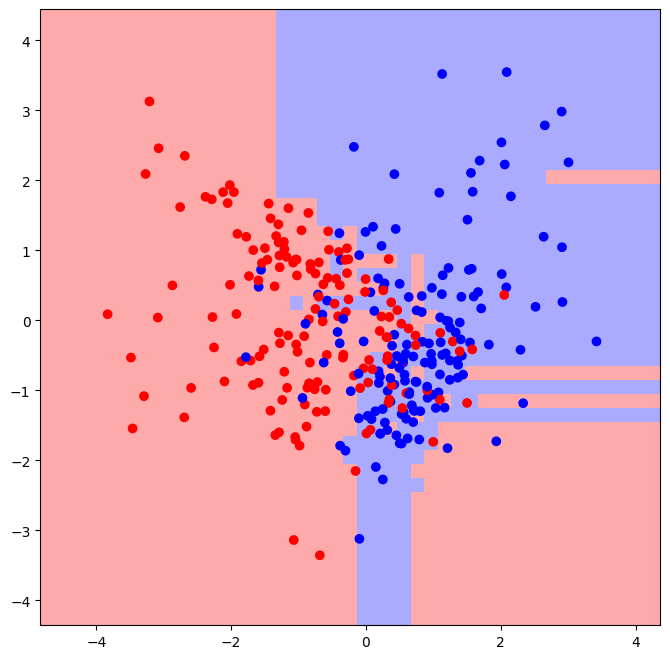

In [15]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(n_estimators=300)
clf.fit(X_train, y_train)
plot_surface(X_test, y_test, clf)

print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

Попробуем подобрать оптимальное количество деревьев

[LightGBM] [Info] Number of positive: 356, number of negative: 344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508571 -> initscore=0.034289
[LightGBM] [Info] Start training from score 0.034289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 356, number of negative: 344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508571 -> initscore=0.034289
[LightGBM]

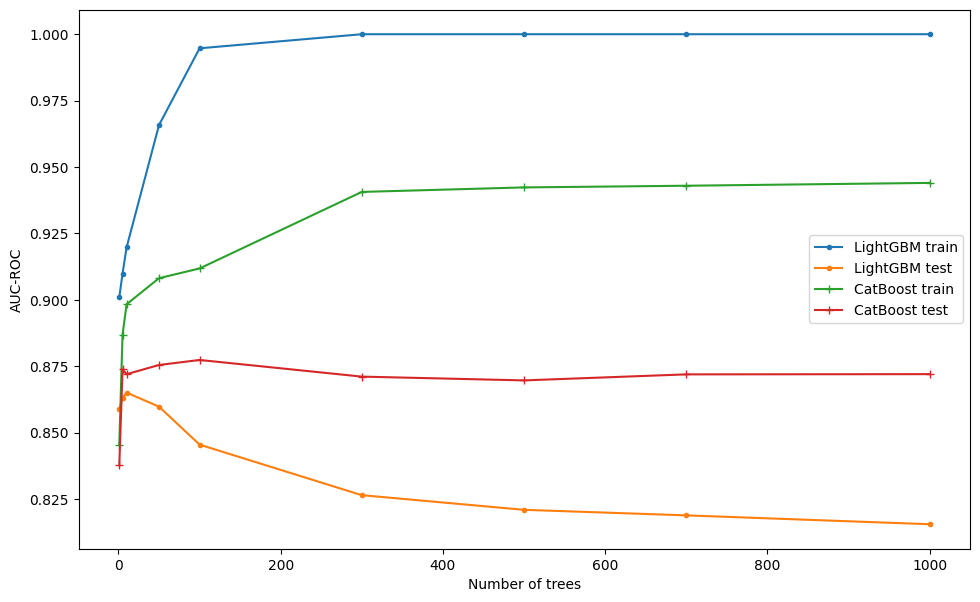

In [16]:
n_trees = [1, 5, 10, 50, 100, 300, 500, 700, 1000]
quals_train_lgb = []
quals_test_lgb = []
quals_train_cbm = []
quals_test_cbm = []

for n in n_trees:
    lgb = LGBMClassifier(n_estimators=n)
    lgb.fit(X_train, y_train)
    q_train_lgb = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_test_lgb = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])

    cbm = CatBoostClassifier(n_estimators=n, logging_level="Silent")
    cbm.fit(X_train, y_train)
    q_train_cbm = roc_auc_score(y_train, cbm.predict_proba(X_train)[:, 1])
    q_test_cbm = roc_auc_score(y_test, cbm.predict_proba(X_test)[:, 1])

    quals_train_lgb.append(q_train_lgb)
    quals_test_lgb.append(q_test_lgb)
    quals_train_cbm.append(q_train_cbm)
    quals_test_cbm.append(q_test_cbm)


plt.figure(figsize=(11.5, 7))
plt.plot(n_trees, quals_train_lgb, marker='.', label='LightGBM train')
plt.plot(n_trees, quals_test_lgb, marker='.', label='LightGBM test')
plt.plot(n_trees, quals_train_cbm, marker='+', label='CatBoost train')
plt.plot(n_trees, quals_test_cbm, marker='+', label='CatBoost test')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

Теперь попробуем взять фиксированное количество деревьев, но будем менять из глубину

[LightGBM] [Info] Number of positive: 356, number of negative: 344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 468
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508571 -> initscore=0.034289
[LightGBM] [Info] Start training from score 0.034289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

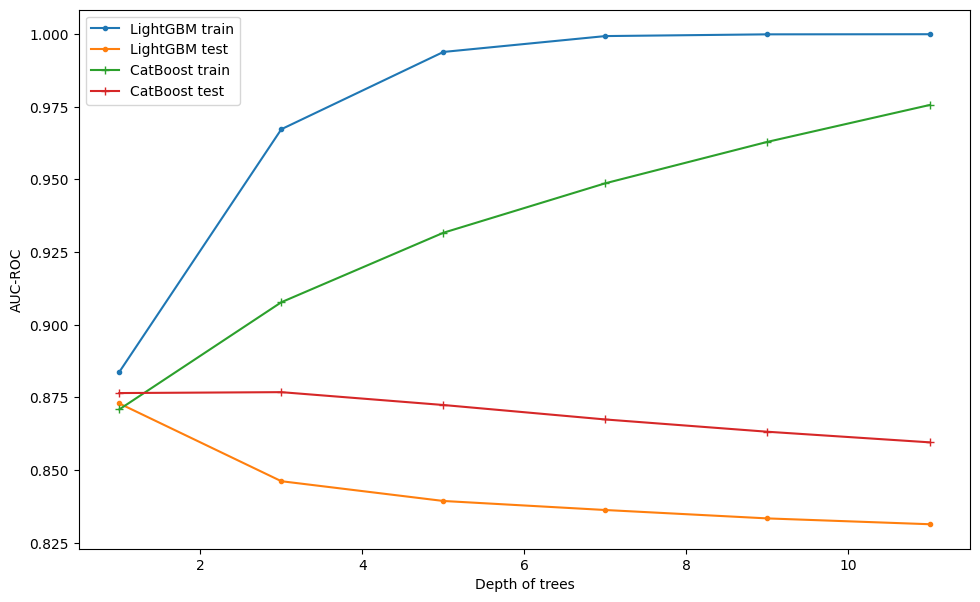

In [17]:
depth = list(range(1, 12, 2))
n_trees = 300
quals_train_lgb = []
quals_test_lgb = []
quals_train_cbm = []
quals_test_cbm = []

for d in depth:
    lgb = LGBMClassifier(n_estimators=n_trees, max_depth=d)
    lgb.fit(X_train, y_train)
    q_train_lgb = roc_auc_score(y_train, lgb.predict_proba(X_train)[:, 1])
    q_test_lgb = roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])

    cbm = CatBoostClassifier(n_estimators=n_trees, max_depth=d, logging_level="Silent")
    cbm.fit(X_train, y_train)
    q_train_cbm = roc_auc_score(y_train, cbm.predict_proba(X_train)[:, 1])
    q_test_cbm = roc_auc_score(y_test, cbm.predict_proba(X_test)[:, 1])

    quals_train_lgb.append(q_train_lgb)
    quals_test_lgb.append(q_test_lgb)
    quals_train_cbm.append(q_train_cbm)
    quals_test_cbm.append(q_test_cbm)


plt.figure(figsize=(11.5, 7))
plt.plot(depth, quals_train_lgb, marker='.', label='LightGBM train')
plt.plot(depth, quals_test_lgb, marker='.', label='LightGBM test')
plt.plot(depth, quals_train_cbm, marker='+', label='CatBoost train')
plt.plot(depth, quals_test_cbm, marker='+', label='CatBoost test')
plt.xlabel('Depth of trees')
plt.ylabel('AUC-ROC')
plt.legend()

plt.show()

## Блендинг

Блендинг представляет из себя "мета-алгоритм", предсказание которого строится как взвешенная сумма базовых алгоритмов. Рассмотрим простой пример блендинга бустинга и линейной регрессии.

In [20]:
import pandas as pd
from sklearn.utils import Bunch
from urllib.request import urlopen

def load_boston():
    url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
    data = pd.read_csv(url)
    X = data.drop('medv', axis=1).values
    y = data['medv'].values
    feature_names = data.columns[:-1]
    return Bunch(data=X, target=y, feature_names=feature_names, DESCR="Boston Housing dataset")

data = load_boston()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

In [21]:
from catboost import CatBoostRegressor

cbm = CatBoostRegressor(iterations=100, max_depth=4, learning_rate=0.01, loss_function='RMSE', logging_level='Silent')
cbm.fit(X_train, y_train)

y_pred_cbm = cbm.predict(X_test)
y_train_pred_cbm = cbm.predict(X_train)

print("Train RMSE GB = %.4f" % rmse(y_train, y_train_pred_cbm))
print("Test RMSE GB = %.4f" % rmse(y_test, y_pred_cbm))

Train RMSE GB = 5.4431
Test RMSE GB = 6.5456


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_train_pred_lr = lr.predict(X_train_scaled)

print("Train RMSE LR = %.4f" % rmse(y_train, y_train_pred_lr))
print("Test RMSE LR = %.4f" % rmse(y_test, y_pred_lr))

Train RMSE LR = 4.4113
Test RMSE LR = 5.4154


Для простоты будем считать, что новый алгоритм $a(x)$ представим как
$$
    a(x)
    =
    \sum_{n = 1}^{N}
    w_n b_n(x),
$$
где $\sum_{n} w_n =1$ и $w_i \ge 0$

In [23]:
def select_weights(y_true, y_pred_1, y_pred_2):
    metric = []
    grid = np.linspace(0, 1, 1000)
    for w_0 in grid:
      w_1 = 1 - w_0
      y = y_pred_1 * w_0 + y_pred_2 * w_1

      metric.append([rmse(y_true, y), w_0, w_1])

    return metric

In [24]:
rmse_blending_train, w_0, w_1 = min(select_weights(y_train, y_train_pred_cbm, y_train_pred_lr), key=lambda x: x[0])

In [25]:
rmse_blending_train

4.273424051954004

In [27]:
print("Test RMSE blending = %.4f" % rmse(y_test, y_pred_cbm * w_0 +  y_pred_lr * w_1))

Test RMSE blending = 5.2373


В итоге получаем качество на тестовой выборке лучше, чем у каждого алгоритма в отдельности.